# Predicción de fuga de clientes con nuevos datos y realización de un simulador de fuga de clientes. 

Una vez hemos realizado en modelo con los datos de diciembre, con los datos de enero vamos a realizar el mismo preprocesado que se relizó con los datos de diciembre y realizaremos predicciones de fuga de clientes con los datos de enero y un simulador de probabilidad de fuga de clientes para el equipo de negocio.

In [1]:
## lo básico
import pandas as pd
import numpy as np

## visualización
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

## pre procesado
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

## modelado
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

## métricas
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report

## mejora de modelos
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

## automatización
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#Funciones 
from funcionesML import tramos, plot_feature_importance, saca_metricas

import math
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

In [2]:
df_jan = pd.read_parquet("df_jan.parquet")

In [4]:
df_jan.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos
0,1,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,None,FIBRA,50MB,tv-futbol,95,19,6525,7634,18520,None,NaN,None
1,2,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,None,FIBRA,600MB,tv-futbol,44,36,14471,14541,8016,None,NaN,SI
2,3,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,None,ADSL,35MB,tv-futbol,94,27,1428,5248,7106,None,NaN,SI
3,4,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,None,FIBRA,200MB,tv-familiar,186,20,20083,7372,5052,None,NaN,None
4,6,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,None,FIBRA,200MB,tv-futbol,37,32,19078,5009,8686,None,NaN,None


In [6]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92711 entries, 0 to 92710
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              92711 non-null  int64  
 1   edad            92711 non-null  int64  
 2   facturacion     92711 non-null  float64
 3   antiguedad      92711 non-null  object 
 4   provincia       92711 non-null  object 
 5   num_lineas      92711 non-null  int64  
 6   num_dt          2614 non-null   float64
 7   incidencia      1991 non-null   object 
 8   conexion        92709 non-null  object 
 9   vel_conexion    92708 non-null  object 
 10  TV              92711 non-null  object 
 11  num_llamad_ent  92711 non-null  int64  
 12  num_llamad_sal  92711 non-null  int64  
 13  mb_datos        92711 non-null  int64  
 14  seg_llamad_ent  92711 non-null  int64  
 15  seg_llamad_sal  92711 non-null  int64  
 16  financiacion    6666 non-null   object 
 17  imp_financ      6666 non-null  

## Reemplazo de nulos estructurales por ceros

In [8]:
df_jan['num_dt'] = df_jan['num_dt'].fillna(0)
df_jan['incidencia'] = df_jan['incidencia'].fillna(0)
df_jan['financiacion'] = df_jan['financiacion'].fillna(0)
df_jan['imp_financ'] = df_jan['imp_financ'].fillna(0)
df_jan['descuentos'] = df_jan['descuentos'].fillna(0)

In [9]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92711 entries, 0 to 92710
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              92711 non-null  int64  
 1   edad            92711 non-null  int64  
 2   facturacion     92711 non-null  float64
 3   antiguedad      92711 non-null  object 
 4   provincia       92711 non-null  object 
 5   num_lineas      92711 non-null  int64  
 6   num_dt          92711 non-null  float64
 7   incidencia      92711 non-null  object 
 8   conexion        92709 non-null  object 
 9   vel_conexion    92708 non-null  object 
 10  TV              92711 non-null  object 
 11  num_llamad_ent  92711 non-null  int64  
 12  num_llamad_sal  92711 non-null  int64  
 13  mb_datos        92711 non-null  int64  
 14  seg_llamad_ent  92711 non-null  int64  
 15  seg_llamad_sal  92711 non-null  int64  
 16  financiacion    92711 non-null  object 
 17  imp_financ      92711 non-null 

In [10]:
df_jan['descuentos'] = df_jan['descuentos'].map({0:0, 'SI': 1})
df_jan['incidencia']=df_jan['incidencia'].map({0:0, 'SI':1})
df_jan['financiacion']=df_jan['financiacion'].map({0:0, 'SI':1})

In [11]:
df_jan['num_lineas'].value_counts()

num_lineas
3    29071
4    25927
5    22161
2    12793
1     2759
Name: count, dtype: int64

In [12]:
df_jan['vel_conexion'].value_counts()

vel_conexion
200MB    9342
600MB    9299
300MB    9212
50MB     9167
100MB    9099
20MB     7882
25MB     7840
10MB     7807
30MB     7761
35MB     7672
15MB     7627
Name: count, dtype: int64

In [13]:
df_jan.isna().sum()

id                0
edad              0
facturacion       0
antiguedad        0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
conexion          2
vel_conexion      3
TV                0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
dtype: int64

En el conjunto de datos de enero hemos detectado algunos valores ausentes en las variables conexion y vel_conexion. A diferencia de diciembre, donde eliminamos esos registros por ser muy pocos y poco relevantes, ahora optamos por imputarlos. El motivo es que necesitamos predecir sobre todos los clientes disponibles, y perder registros podría reducir el alcance del modelo. Como los nulos son pocos y los datos tienen valor para el negocio, completarlos nos permite mantener la calidad y utilidad del análisis.

In [15]:
df_jan[df_jan.isnull().any(axis=1)]


,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos
57,63,28,183.353127,10/27/2018 10:37 PM,Palencia,5,0.0,0,None,100MB,tv-familiar,80,26,16659,3649,14213,0,0.0,1
58,65,85,369.220953,09/23/2002 11:09 AM,Álava,3,0.0,0,None,30MB,tv-total,152,74,304,17449,12919,0,0.0,0
200,215,54,126.570011,04/03/2003 12:47 AM,Cantabria,5,0.0,0,ADSL,None,tv-futbol,114,94,21443,12555,4524,0,0.0,0
201,216,60,179.288551,10/01/1995 10:34 AM,Málaga,3,0.0,0,ADSL,None,tv-futbol,212,74,16951,10913,619,0,0.0,1
202,217,52,187.078300,12/09/2010 02:19 PM,Almería,3,0.0,0,FIBRA,None,tv-familiar,35,20,1146,12066,19098,0,0.0,1


In [21]:
# ¿Qué tipo de conexión tienen los clientes con 15MB?
(df_jan[df_jan['vel_conexion'] == '15MB']['conexion'].value_counts())


conexion
ADSL    7627
Name: count, dtype: int64

In [20]:
# ¿Qué tipo de conexión tienen los clientes con 15MB?
(df_jan[df_jan['vel_conexion'] == '100MB']['conexion'].value_counts())

conexion
FIBRA    9098
Name: count, dtype: int64

In [22]:
# ¿Qué tipo de conexión tienen los clientes con ADSL? Aquí veremos la conexión más utilizada. 
(df_jan[df_jan['conexion'] == 'ADSL']['vel_conexion'].value_counts())

vel_conexion
20MB    7882
25MB    7840
10MB    7807
30MB    7760
35MB    7672
15MB    7627
Name: count, dtype: int64

In [23]:
# ¿Qué tipo de conexión tienen los clientes con FIBRA? Aquí veremos la conexión más utilizada. 
(df_jan[df_jan['conexion'] == 'FIBRA']['vel_conexion'].value_counts())

vel_conexion
200MB    9342
600MB    9299
300MB    9212
50MB     9167
100MB    9098
Name: count, dtype: int64

In [24]:
# Si conexión es ADSL y vel_conexion está vacía → imputamos con 20MB
df_jan.loc[(df_jan['conexion'] == 'ADSL') & (df_jan['vel_conexion'].isna()), 'vel_conexion'] = '20MB'
# Si conexión es FIBRA y vel_conexion está vacía → imputamos con 200MB
df_jan.loc[(df_jan['conexion'] == 'FIBRA') & (df_jan['vel_conexion'].isna()), 'vel_conexion'] = '200MB'
# Si vel_conexion es 15MB y conexión está vacía → imputamos con ADSL
df_jan.loc[(df_jan['vel_conexion'] == '15MB') & (df_jan['conexion'].isna()), 'conexion'] = 'ADSL'
# Si vel_conexion es 100MB y conexión está vacía → imputamos con FIBRA
df_jan.loc[(df_jan['vel_conexion'] == '100MB') & (df_jan['conexion'].isna()), 'conexion'] = 'FIBRA'


Para imputar los valores ausentes, nos hemos guiado por el conocimiento del negocio y los patrones del propio dataset. Vimos que los clientes con 15MB siempre tienen ADSL, y los de 100MB usan solo FIBRA. Además, entre quienes tenían conexión pero no velocidad, las más comunes eran 20MB para ADSL y 200MB para FIBRA. Por eso, hemos imputado usando estas combinaciones frecuentes, manteniendo la coherencia con el producto y asegurando que el modelo reciba datos consistentes.

## Transformacion de variable antigüedad

In [25]:
# Convertimos la columna a formato datetime
df_jan.loc[:, 'antiguedad'] = pd.to_datetime(df_jan['antiguedad'], errors='coerce')

In [26]:
# Comprobamos el rango de fechas de alta de los clientes
fecha_min = df_jan['antiguedad'].min()
fecha_max = df_jan['antiguedad'].max()
print(f"Fecha mínima de alta: {fecha_min}")
print(f"Fecha máxima de alta: {fecha_max}")

Fecha mínima de alta: 1995-01-01 15:23:00
Fecha máxima de alta: 2020-01-31 04:46:00


In [27]:
fecha_corte = pd.to_datetime('2020-01-31')

In [29]:
# Calculamos la antigüedad en días desde la fecha de alta hasta la fecha de corte (diciembre 2019)
df_jan = df_jan.copy()
df_jan['antiguedad'] = pd.to_datetime(df_jan['antiguedad'], errors='coerce')
df_jan['antiguedad_dias'] = (fecha_corte - df_jan['antiguedad']).dt.days

In [30]:
# Mostramos algunos ejemplos para verificar el resultado
print(df_jan[['antiguedad', 'antiguedad_dias']].head())

           antiguedad  antiguedad_dias
0 2018-11-23 08:48:00              433
1 2017-08-22 03:19:00              891
2 2001-12-27 13:50:00             6608
3 2015-08-08 10:53:00             1636
4 1997-11-04 11:43:00             8122


In [31]:
#Eliminamos la columna original 
df_jan.drop(columns='antiguedad', inplace=True)

In [32]:
df_jan.head()

,id,edad,facturacion,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,antiguedad_dias
0,1,63,216.028109,La Rioja,5,0.0,0,FIBRA,50MB,tv-futbol,95,19,6525,7634,18520,0,0.0,0,433
1,2,84,255.830842,Vizcaya,3,0.0,0,FIBRA,600MB,tv-futbol,44,36,14471,14541,8016,0,0.0,1,891
2,3,66,135.768153,Albacete,4,0.0,0,ADSL,35MB,tv-futbol,94,27,1428,5248,7106,0,0.0,1,6608
3,4,69,255.658527,Lugo,4,0.0,0,FIBRA,200MB,tv-familiar,186,20,20083,7372,5052,0,0.0,0,1636
4,6,51,99.348645,Huelva,4,0.0,0,FIBRA,200MB,tv-futbol,37,32,19078,5009,8686,0,0.0,0,8122


## Transformación de la variable provincia

In [33]:
map_provincia_ccaa = {
    'Almería': 'Andalucía',
    'Cádiz': 'Andalucía',
    'Córdoba': 'Andalucía',
    'Granada': 'Andalucía',
    'Huelva': 'Andalucía',
    'Jaén': 'Andalucía',
    'Málaga': 'Andalucía',
    'Sevilla': 'Andalucía',
    'Huesca': 'Aragón',
    'Teruel': 'Aragón',
    'Zaragoza': 'Aragón',
    'Asturias': 'Asturias',
    'Cantabria': 'Cantabria',
    'Ávila': 'Castilla y León',
    'Burgos': 'Castilla y León',
    'León': 'Castilla y León',
    'Palencia': 'Castilla y León',
    'Salamanca': 'Castilla y León',
    'Segovia': 'Castilla y León',
    'Soria': 'Castilla y León',
    'Valladolid': 'Castilla y León',
    'Zamora': 'Castilla y León',
    'Albacete': 'Castilla-La Mancha',
    'Ciudad Real': 'Castilla-La Mancha',
    'Cuenca': 'Castilla-La Mancha',
    'Guadalajara': 'Castilla-La Mancha',
    'Toledo': 'Castilla-La Mancha',
    'Barcelona': 'Cataluña',
    'Gerona': 'Cataluña',
    'Girona': 'Cataluña',
    'Lérida': 'Cataluña',
    'Lleida': 'Cataluña',
    'Tarragona': 'Cataluña',
    'Alicante': 'Comunidad Valenciana',
    'Castellón': 'Comunidad Valenciana',
    'Valencia': 'Comunidad Valenciana',
    'Badajoz': 'Extremadura',
    'Cáceres': 'Extremadura',
    'La Coruña': 'Galicia',
    'A Coruña': 'Galicia',
    'Lugo': 'Galicia',
    'Orense': 'Galicia',
    'Ourense': 'Galicia',
    'Pontevedra': 'Galicia',
    'Madrid': 'Madrid',
    'Murcia': 'Murcia',
    'Navarra': 'Navarra',
    'Álava': 'País Vasco',
    'Vizcaya': 'País Vasco',
    'Guipúzcoa': 'País Vasco',
    'La Rioja': 'La Rioja',
    'Islas Baleares': 'Islas Baleares',
    'Las Palmas': 'Islas Canarias',
    'Santa Cruz de Tenerife': 'Islas Canarias',
    'Ceuta': 'Ceuta',
    'Melilla': 'Melilla'
}


In [34]:
df_jan['ccaa'] = df_jan['provincia'].map(map_provincia_ccaa)

In [35]:
df_jan['ccaa'].value_counts()

ccaa
Castilla y León         16577
Andalucía               14977
Castilla-La Mancha       9123
Galicia                  7428
Cataluña                 7345
Comunidad Valenciana     5690
País Vasco               5526
Aragón                   5526
Extremadura              3724
Islas Canarias           3664
Asturias                 1934
Murcia                   1931
Navarra                  1930
Islas Baleares           1864
Madrid                   1849
La Rioja                 1816
Cantabria                1807
Name: count, dtype: int64

In [36]:
df_jan.drop('provincia', axis=1, inplace=True)

In [37]:
df_jan.head()

,id,edad,facturacion,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,antiguedad_dias,ccaa
0,1,63,216.028109,5,0.0,0,FIBRA,50MB,tv-futbol,95,19,6525,7634,18520,0,0.0,0,433,La Rioja
1,2,84,255.830842,3,0.0,0,FIBRA,600MB,tv-futbol,44,36,14471,14541,8016,0,0.0,1,891,País Vasco
2,3,66,135.768153,4,0.0,0,ADSL,35MB,tv-futbol,94,27,1428,5248,7106,0,0.0,1,6608,Castilla-La Mancha
3,4,69,255.658527,4,0.0,0,FIBRA,200MB,tv-familiar,186,20,20083,7372,5052,0,0.0,0,1636,Galicia
4,6,51,99.348645,4,0.0,0,FIBRA,200MB,tv-futbol,37,32,19078,5009,8686,0,0.0,0,8122,Andalucía


## Transformación de la variable vel_conexion

In [38]:
df_jan['vel_conexion'].dtype

dtype('O')

In [39]:
df_jan['vel_conexion'] = df_jan['vel_conexion'].str.replace('MB', '').astype(int)

In [40]:
df_jan['vel_conexion'].dtype

dtype('int32')

In [41]:
df_jan['vel_conexion'].value_counts()

vel_conexion
200    9343
600    9299
300    9212
50     9167
100    9099
20     7884
25     7840
10     7807
30     7761
35     7672
15     7627
Name: count, dtype: int64

## Creación de variables derivadas

In [45]:
# Total de llamadas
df_jan['llamadas_total'] = df_jan['num_llamad_ent'] + df_jan['num_llamad_sal']
# Duración total de llamadas
df_jan['segundos_total'] = df_jan['seg_llamad_ent'] + df_jan['seg_llamad_sal']
# Ratio datos/llamadas
df_jan['ratio_datos_llamadas'] = df_jan['mb_datos'] / (df_jan['llamadas_total'] + 1)
# Gasto total relacionado con financiación
df_jan['gasto_total'] = df_jan['imp_financ'] + df_jan['descuentos']
# Facturación por línea
df_jan['facturacion_por_linea'] = df_jan['facturacion'] / (df_jan['num_lineas'] + 1)

## Creación de la variable impago

In [49]:
df_jan['impago'] = (df_jan['num_dt'] > 0).astype(int)
df_jan.drop('num_dt', axis=1, inplace=True)

## Guardado del dataset como CSV una vez limpio para realizar el modelado

In [50]:
df_jan.to_parquet("df_jan_preprocessed.parquet")

## Cargamos el modelo y aplicamos las predicciones.

In [51]:
# Cargamos el pipeline del modelo
pipeline, *_ = joblib.load("churn_model.pkl")

In [52]:
# Realizamos predicciones
df_jan['pred_clase'] = pipeline.predict(df_jan)
df_jan['pred_prob'] = pipeline.predict_proba(df_jan)[:, 1]

In [53]:
df_jan.head()

,id,edad,facturacion,num_lineas,incidencia,conexion,vel_conexion,TV,num_llamad_ent,num_llamad_sal,...,antiguedad_dias,ccaa,llamadas_total,segundos_total,ratio_datos_llamadas,gasto_total,facturacion_por_linea,impago,pred_clase,pred_prob
0,1,63,216.028109,5,0,FIBRA,50,tv-futbol,95,19,...,433,La Rioja,114,26154,56.739130,0.0,36.004685,0,0,0.005238
1,2,84,255.830842,3,0,FIBRA,600,tv-futbol,44,36,...,891,País Vasco,80,22557,178.654321,1.0,63.957710,0,0,0.000000
2,3,66,135.768153,4,0,ADSL,35,tv-futbol,94,27,...,6608,Castilla-La Mancha,121,12354,11.704918,1.0,27.153631,0,0,0.000000
3,4,69,255.658527,4,0,FIBRA,200,tv-familiar,186,20,...,1636,Galicia,206,12424,97.019324,0.0,51.131705,0,0,0.000000
4,6,51,99.348645,4,0,FIBRA,200,tv-futbol,37,32,...,8122,Andalucía,69,13695,272.542857,0.0,19.869729,0,0,0.000000


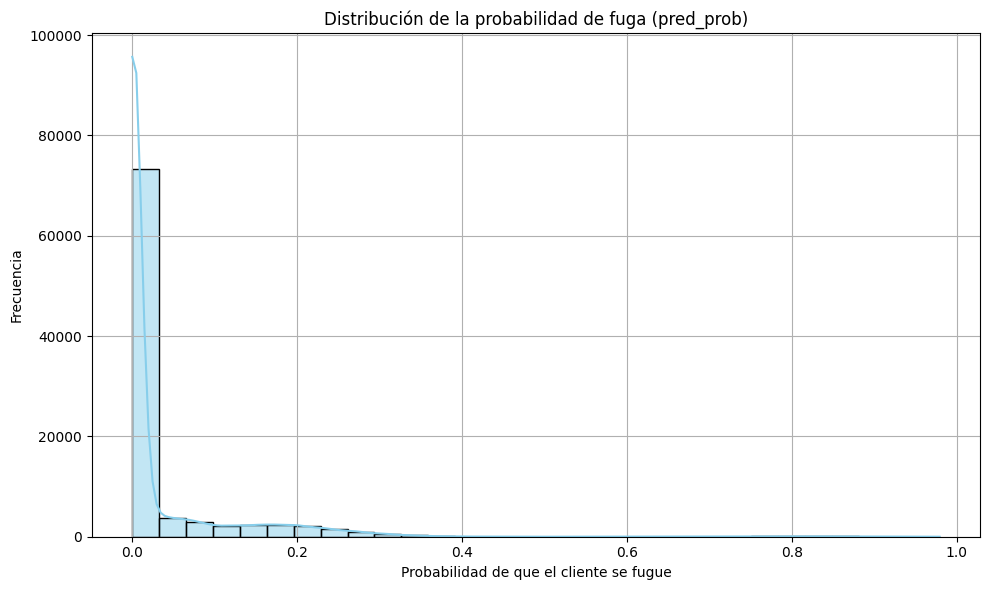

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(df_jan['pred_prob'], bins=30, kde=True, color='skyblue')
plt.title("Distribución de la probabilidad de fuga (pred_prob)")
plt.xlabel("Probabilidad de que el cliente se fugue")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
df_jan['pred_clase'].value_counts()

pred_clase
0    92268
1      443
Name: count, dtype: int64

Tras aplicar el modelo entrenado sobre los clientes del mes de enero, observamos que únicamente un pequeño porcentaje de ellos ha sido clasificado como clientes con alta probabilidad de fuga. Concretamente, el modelo ha identificado 443 clientes en riesgo de abandonar la compañía frente a más de 92.000 que permanecerían.

Este comportamiento es coherente con la realidad de negocio. En sectores como las telecomunicaciones, las tasas de fuga mensual suelen ser bajas. Por tanto, es esperable que la mayoría de los clientes no presenten señales de abandono inminente. El objetivo del modelo es detectar con precisión aquellos perfiles que realmente se asemejan a los casos de fuga observados en el pasado.

Desde el punto de vista estratégico, esta predicción resulta altamente útil, ya que permite a la empresa concentrar sus esfuerzos de retención en un grupo reducido pero bien segmentado de clientes con alto riesgo, optimizando así los recursos disponibles y mejorando el retorno de las acciones comerciales.